In [26]:
import warnings
warnings.filterwarnings("ignore")

## Data preprocessing

In [27]:
# necessary imports
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from tqdm.notebook import tqdm

In [28]:
# read train data
train_df = pd.read_csv(
    "mnist_train.csv", header=None
)
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
# split images and labels
labels = train_df[0].values
images = train_df.drop(0, axis=1).values.reshape(-1, 28, 28) / 255

In [30]:
# Preprocess images
import torchvision.transforms as transforms

transform = transforms.Compose(
    [
        transforms.ToTensor()
    ]
)


In [31]:
# convert data to tensors
images = torch.stack([transform(image).float() for image in images])
labels = torch.from_numpy(labels)

In [32]:
import matplotlib.pyplot as plt


def plot_images(images, captions=[], rows=2, columns=5, title="", **kwargs):
    """
    Plots images with captions

    :param images: list of images to plot
    :param captions: captions of images:
    :param rows: number of rows in figure
    :param columns: number of columns:
    :param title: super title of figure
    """
    fig = plt.figure(figsize=(6, 3))
    for i, img in enumerate(images):
        fig.add_subplot(rows, columns, i + 1)
        plt.imshow(img, **kwargs)
        if i < len(captions):
            plt.title(captions[i])
        plt.axis("off")
    fig.suptitle(title)
    plt.show()

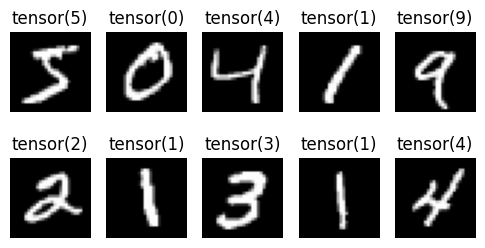

In [33]:
plot_images(images[:10].permute((0, 2, 3, 1)), captions=labels[:10], cmap="gray")

In [34]:
from torch.utils.data import TensorDataset, DataLoader

processed_dataset = TensorDataset(images, labels)

# set proportion and split dataset into train and validation parts
proportion = 0.99
train_dataset, val_dataset = torch.utils.data.random_split(
    processed_dataset,
    (int(len(images) * proportion), int(len(images) * (1 - proportion))),
)


In [35]:
# Create Dataloaders for training
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

## Model

In [36]:
class CNNClassificationModel(nn.Module):
    """
    CNN (convolutional neural network) based classification model for MNIST
    """

    def __init__(self, num_classes=10):
        super(CNNClassificationModel, self).__init__()
        feature_extractor = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3),
            nn.Conv2d(32, 64, kernel_size=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 128, kernel_size=2),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((6, 6)),
        )
        classifier = nn.Sequential(
            nn.Linear(128 * 6 * 6, 1024),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.Dropout(p=0.1),
            nn.ReLU(),
            nn.Linear(256, num_classes),
        )

        self.model = nn.Sequential(feature_extractor, nn.Flatten(), classifier)

    def forward(self, x):
        return self.model(x)


In [37]:
class ClassificationModel(nn.Module):
    """
    MLP (multi-layer perceptron) based classification model for MNIST
    """

    def __init__(self, num_classes=10):
        super(ClassificationModel, self).__init__()

        # Add fully connected layers to nn.Sequential to create MLP
        # First layer should take 28x28 vector
        # last layer should return vector of size num_classes
        # do not forget to add activation function between layers

        self.model = nn.Sequential(
            nn.Linear(28 * 28, 50),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(50, num_classes),
        )

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        return self.model(x)


## Training

In [38]:
def train(
    model,
    optimizer,
    loss_fn,
    train_loader,
    val_loader,
    epochs=1,
    device="cpu",
    ckpt_path="best.pt",
):
    # best score for checkpointing
    best = 0.0

    # iterating over epochs
    for epoch in range(epochs):
        # training loop description
        train_loop = tqdm(
            enumerate(train_loader, 0), total=len(train_loader), desc=f"Epoch {epoch}"
        )
        model.train()
        train_loss = 0.0
        # iterate over dataset
        for i, data in train_loop:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward pass and loss calculation
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            # backward pass
            loss.backward()

            # optimizer run
            optimizer.step()

            train_loss += loss.item()
            train_loop.set_postfix({"loss": loss.item()})


        # validation
        correct = 0
        total = 0
        with torch.no_grad():
            model.eval()  # evaluation mode
            val_loop = tqdm(enumerate(val_loader, 0), total=len(val_loader), desc="Val")
            for i, data in val_loop:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                val_loop.set_postfix({"acc": correct / total})

            if correct / total > best:
                torch.save(model.state_dict(), ckpt_path)
                best = correct / total


In [39]:
model = ClassificationModel()
optimizer = torch.optim.Adam(model.parameters())
loss_fn = torch.nn.CrossEntropyLoss()
device = 'cpu' # problems with gpu

In [40]:
train(
    model,
    optimizer,
    loss_fn,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
)


Epoch 0:   0%|          | 0/929 [00:00<?, ?it/s]

Val:   0%|          | 0/10 [00:00<?, ?it/s]

## Inference
Here you need to perform inference of trained model on test data.

Load the best checkpoint from training to the model and run inference

In [41]:
# load best checkpoint to model
model = ClassificationModel()
ckpt = torch.load("best.pt")
model.load_state_dict(ckpt)

<All keys matched successfully>

In [42]:
def predict(model, test_loader, device):
    """
    Run model inference on test data
    """
    predictions = []
    with torch.no_grad():
        model.eval()  # evaluation mode
        test_loop = tqdm(enumerate(test_loader, 0), total=len(test_loader), desc="Test")
        for i, inputs in test_loop:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            predictions.extend(predicted.tolist())
        return predictions


In [43]:
# read test data
test_df = pd.read_csv("mnist_test.csv", header=None)
test_df.head()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [44]:
# process test data and run inference on it
images = test_df.values.reshape(-1,28, 28)/255
images = torch.stack([transform(image).float() for image in images])
test_loader = DataLoader(images, batch_size=batch_size, shuffle=False)
predictions = predict(model, test_loader, device=device)

Test:   0%|          | 0/157 [00:00<?, ?it/s]

In [45]:
# generate the submission file
answer_df = pd.DataFrame(columns=['id', 'label'])
answer_df['id'] = test_df.index
answer_df['label'] = predictions
answer_df

,id,label
0,0,7
1,1,2
2,2,1
3,3,0
4,4,4
...,...,...
9995,9995,2
9996,9996,3
9997,9997,4
9998,9998,5
